In [15]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

Import the survey and process the GRBs

In [ ]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True)

In [ ]:
ab.write_yaml("test_proc.yml")

In [16]:
ds = DataSet.from_yaml("test_proc.yml")

In [ ]:
ds.to_hdf5_file("sgrb.h5")

In [ ]:
ds.to_hdf5_file("sgrb.h5", sig_threshold=40)

In [ ]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [45]:
ds.to_stan_dict()

OrderedDict([('N_intervals', 12),
             ('N_grbs', 2),
             ('max_n_echan', 140),
             ('max_n_chan', 128),
             ('object_idx', array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])),
             ('grb_id', array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])),
             ('N_dets', [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
             ('observed_counts',
              array([[[32., 14., 17., ...,  1.,  0.,  5.],
                      [ 5.,  0.,  5., ...,  1.,  0.,  7.],
                      [ 8.,  3.,  3., ...,  0.,  0.,  8.],
                      [ 5.,  5., 11., ...,  0.,  3.,  5.]],
              
                     [[34., 19., 14., ...,  1.,  0.,  4.],
                      [ 8.,  4.,  4., ...,  0.,  3.,  8.],
                      [ 1.,  2.,  2., ...,  0.,  0.,  5.],
                      [ 4.,  7.,  1., ...,  1.,  3.,  6.]],
              
                     [[34., 24., 15., ...,  0.,  0., 10.],
                      [ 5.,  5.,  6., ...,  0.,  3., 22.],
       

Make Stan model

In [24]:
m = get_model("cpl_simple_chunked_gc")

In [25]:
m.clean_model()

In [26]:
m.build_model(opt_exp=True)

09:14:28 - cmdstanpy - INFO - compiling stan file /home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan to exe file /home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc
09:15:13 - cmdstanpy - INFO - compiled model executable: /home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc
09:15:13 - cmdstanpy - WARNING - Stan compiler has produced 26 warnings:
09:15:13 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --Oexperimental --include-paths=/home/chhecker/zusammen/zusammen/stan_models --o=/home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.hpp /home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan
Warning in '/home/chhecker/zusammen/zusammen/stan_models/cpl.stan', line 35, column 41, included from
'/home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 2, column 0: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed

In [48]:
data = ds.to_stan_dict()

n_threads = 16
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    # inits= {'alpha':-1.},
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=15,
    adapt_delta=0.9,
    show_progress=True,
    #show_console=True
)

13:40:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

20:24:58 - cmdstanpy - INFO - CmdStan done processing.
20:24:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 170, column 2 to column 60)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 169, column 2 to column 48)
	Exception: integrate: error estimate of integral 6.06096e-05 exceeds the given relative tolerance times norm of integral (in '/home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 3.72936e-05 exceeds the given relative tolerance times norm of integral (in '/home/chhecker/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of inte

Import Stan results into arviz

In [49]:
res = av.from_cmdstanpy(fit)

In [50]:
res.to_netcdf("inference_data/test_inference_data_exact_4.nc")

'inference_data/test_inference_data_exact_4.nc'

In [ ]:
res = av.from_netcdf("inference_data/test_inference_data_exact_2.nc")

In [53]:
res.sample_stats.tree_depth.max()

<xarray.DataArray 'tree_depth' ()>
array(12)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_Nrest'}>,
        <AxesSubplot:title={'center':'log_Nrest'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'gamma_mu_meta'}>,
        <AxesSubplot:title={'center':'gamma_mu_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_mu_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_mu_meta'}>],
       [<AxesSubplot:title={'center':'gamma_sig_meta'}>,
        <AxesSubplot:title={'center':'gamma_sig_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_sig_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_sig_meta'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'l

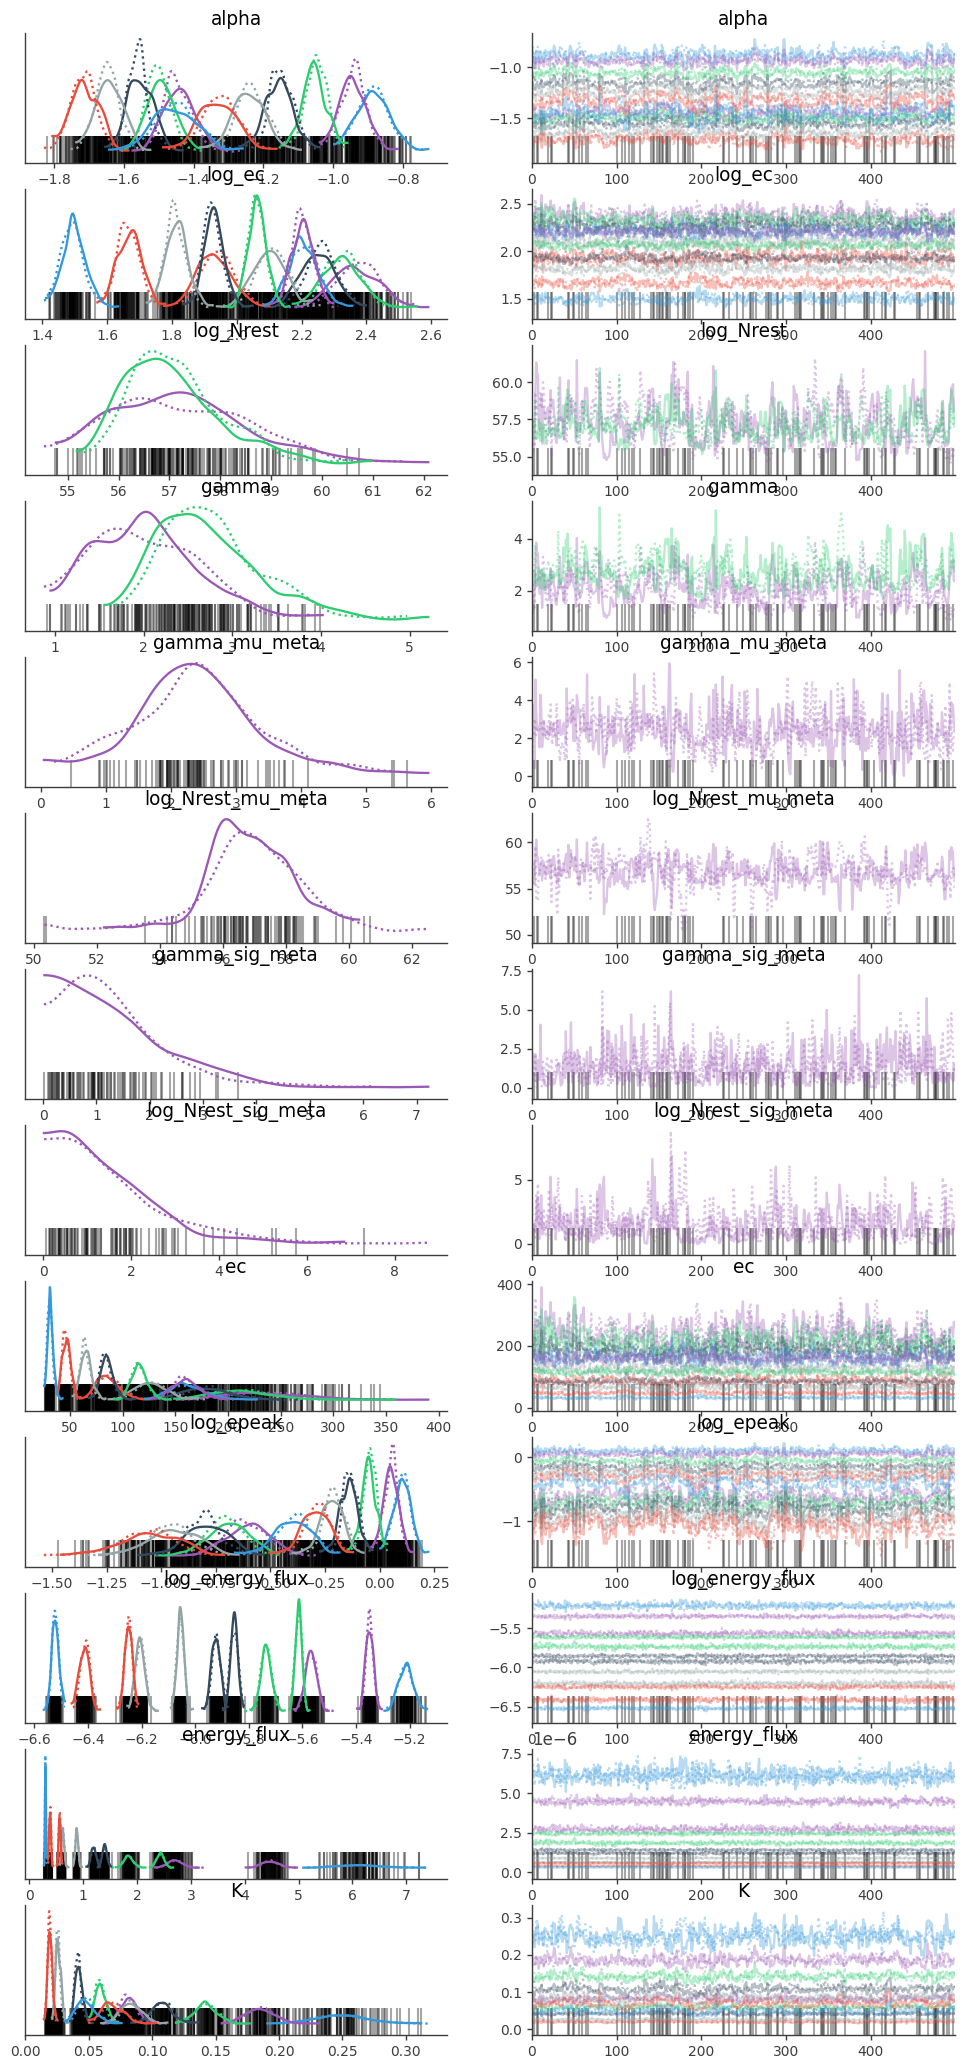

In [54]:
%matplotlib widget
av.plot_trace(res)

array([[<AxesSubplot:ylabel='alpha\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='alpha\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='alpha\n3'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='alpha\n4'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='alpha\n5'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='alpha\n6'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
     

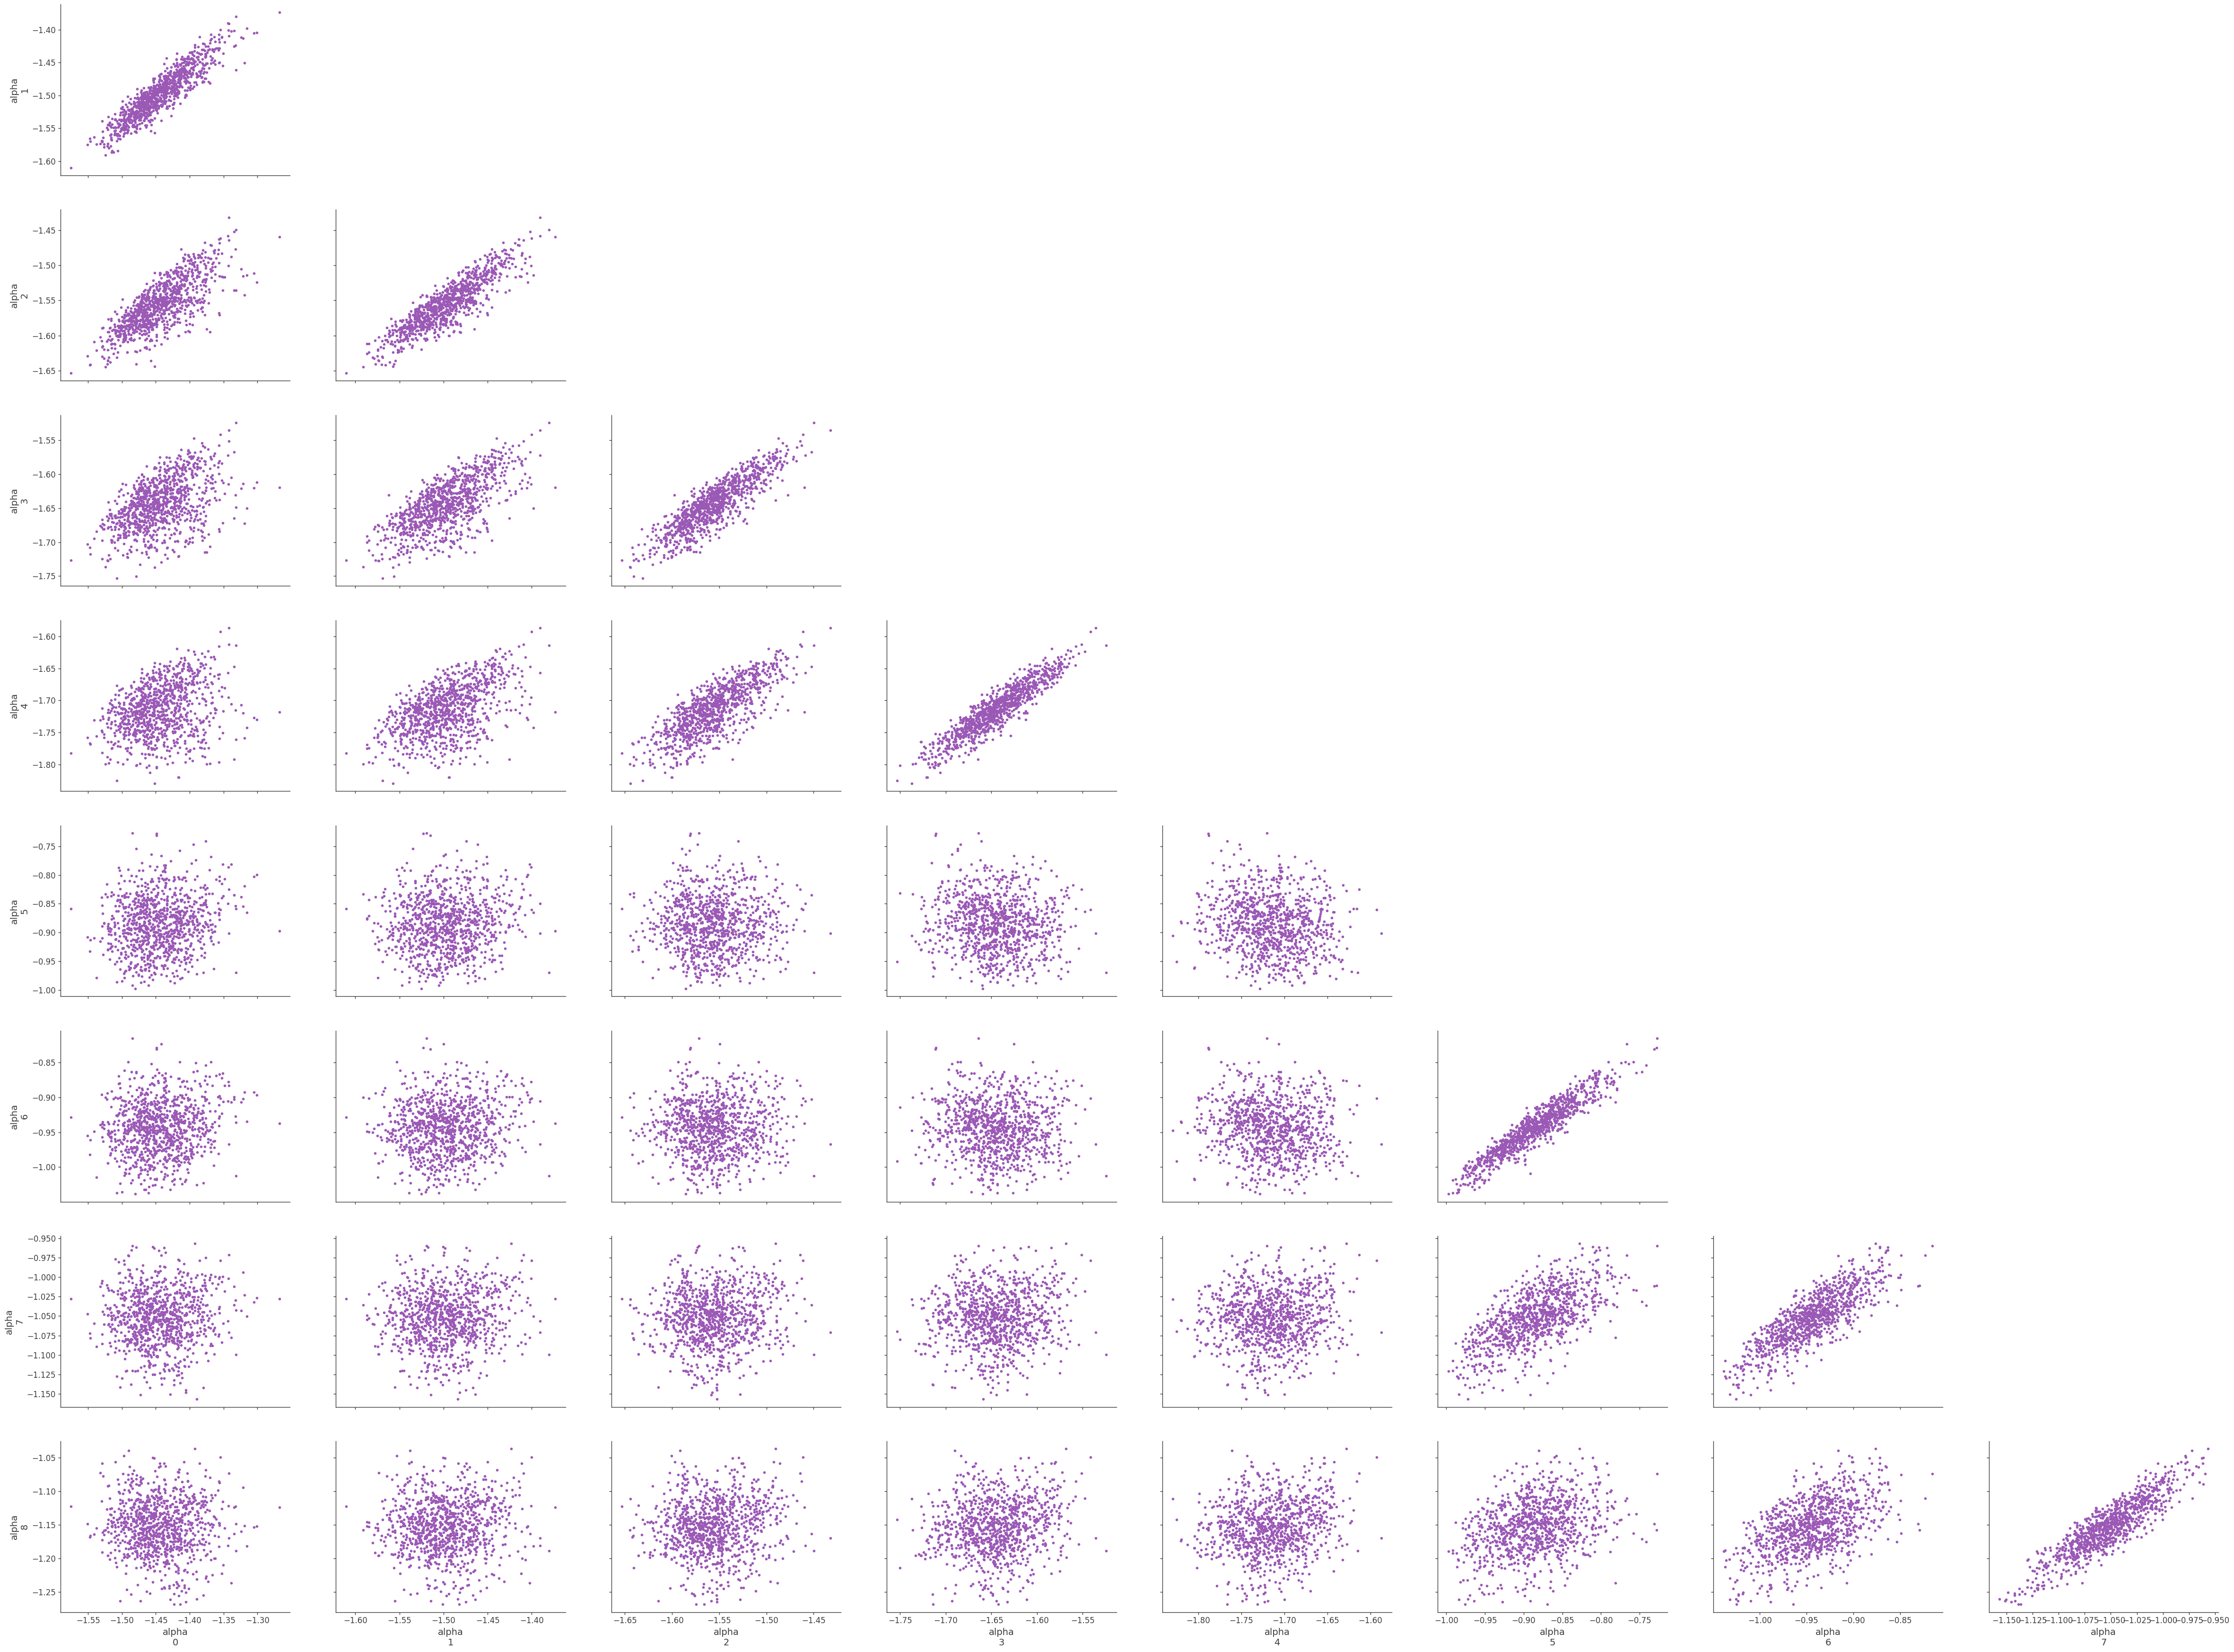

In [55]:
av.plot_pair(res)

In [ ]:
bc = Band_Calderone(opt=0, a =10, b=1e4)
bc.beta.fix = True

Load parameters  
    $\alpha$: parameter of CPL  
    $E_p = \log E_c$  
    $K$: normalization

In [37]:
id = 0

In [40]:
alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

log_ec = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]

log_epeak = res.posterior.log_epeak.stack(sample=("chain", "draw")).values[id]

energy_flux = res.posterior.energy_flux.stack(sample=("chain", "draw")).values[id]

gamma = res.posterior.gamma.stack(sample=("chain", "draw")).values[id]

log_Nrest = res.posterior.log_Nrest.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**log_ec))


dl = ds.get_data_list_of_interval(id)

In [47]:
log_Nrest

array([59.9245, 59.0882, 57.2902, 54.8354, 55.1241, 55.2019, 55.029 ,
       55.0639, 55.1049, 55.3423, 55.5706, 55.9363, 55.6257, 55.762 ,
       58.2991, 56.9679, 57.1328, 56.9071, 57.5849, 56.1291, 58.2441,
       58.1778, 56.8271, 57.4337, 57.3707, 57.7225, 57.7062, 55.2392,
       54.9743, 57.7821, 57.26  , 57.2288, 57.7829, 56.8468, 56.2226,
       56.3929, 56.0686, 56.629 , 58.5668, 57.9558, 59.1525, 57.8263,
       57.3774, 57.7673, 59.9346, 57.7575, 57.1878, 56.2078, 55.9847,
       58.6864, 58.9828, 59.9683, 59.2717, 56.9486, 58.0581, 57.7572,
       57.3449, 57.3442, 57.0464, 58.5396, 59.0508, 58.2796, 59.6165,
       57.6307, 56.7446, 56.7243, 56.2733, 57.3735, 57.6878, 58.1735,
       58.1161, 57.3761, 57.3957, 57.5276, 56.4579, 56.9669, 57.272 ,
       55.951 , 55.9996, 55.01  , 55.1932, 55.7384, 55.3117, 55.4364,
       57.261 , 56.7523, 55.9974, 56.1562, 56.1691, 57.3642, 56.665 ,
       57.2581, 55.6611, 58.024 , 58.3563, 58.6245, 56.334 , 56.5456,
       56.3689, 57.1

In [ ]:
div.sum()

In [ ]:
bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

In [ ]:
fig, ax = plt.subplots()


ax.scatter(ep, alpha, alpha=0.1)


In [ ]:
fig, ax = plt.subplots()


ax.scatter(K, alpha, alpha=0.1)

In [ ]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [ ]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [ ]:
ba.fit()

In [ ]:
display_spectrum_model_counts(ba)

In [ ]:
dl[0].view_count_spectrum()

In [ ]:
cpl